# day 3 tutorial

Run the whole notebook by selecting "Restart & Run All" from the "Kernel" menu (above).

**TO RUN LOCALLY users need to install ipywidgets and ipyleaflet and enable the widget extension for jupyter:**
```
pip install ipywidgets
pip install ipyleaflet
jupyter nbextension enable --py widgetsnbextension
```
**notes:**
* old code that Yaxing might still want to use is at bottom


In [1]:
import os
import math
import json
import requests

import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

from io import StringIO
from shapely.geometry import Point

import ipywidgets as wg
import ipyleaflet as mwg
import matplotlib.pyplot as plt
from matplotlib import cm, colors

import warnings
warnings.filterwarnings('ignore')

save_samples = "sites/samples/" # SMV downloads won't be saved if None

## SMV Datasets

[*docs/smvdatasets.csv*](docs/smvdatasets.csv) is a copy of the datasets table from the [SMV User Guide](https://daac.ornl.gov/soilmoisture/guide.html). Read it into a `pandas` data frame and display it:

In [2]:
smvds = pd.read_csv("docs/smvdatasets.csv", index_col="Column fieldname", header=0)
smvds

,Description,Units
Column fieldname,,
SoilSCAPE_surface,Mean volumetric (%) soil moisture at 0-5 cm so...,m3/m3
SoilSCAPE_rootzone,Mean volumetric (%) soil moisture at 0-100 cm ...,m3/m3
AirMOSS_in-ground_surface,Mean volumetric (%) soil moisture at 0-5 cm so...,m3/m3
AirMOSS_in-ground_rootzone,Mean volumetric (%) soil moisture at 0-100 cm ...,m3/m3
COSMOS_surface,Mean volumetric (%) soil moisture at 0-5 cm so...,m3/m3
COSMOS_rootzone,Mean volumetric (%) soil moisture at 0-100 cm ...,m3/m3
AirMOSS_L2_3_surface,Mean volumetric (%) soil moisture at 0 cm soil...,m3/m3
AirMOSS_L2_3_rootzone,Mean volumetric (%) soil moisture at 0-30cm so...,m3/m3
AirMOSS_L4_rootzone,Mean volumetric (%) soil moisture at 0-100cm s...,m3/m3


## Download a SMV dataset with `requests`
Example: https://daac.ornl.gov/cgi-bin/viz/download.pl? + lt=**32.8129**&ln=**-109.4379**&d=**smap**

Normally the response text may be passed to `pandas.read_csv()` as a pseudo-file using `io.StringIO()`:
```
url = "https://daac.ornl.gov/cgi-bin/viz/download.pl?"
inlat, inlon = 30, -100

r = requests.get(
    "".join([url, "lt=", str(inlat), "&ln=", str(inlon), "&d=smap"]),
    cookies=dict(ORNL_DAAC_USER_NUM="10"))

lat, lon = StringIO(r.text).readlines()[2].split("Location: ")[1].strip().split(", ")
df = pd.read_csv(StringIO(r.text), header=4, index_col="time")
```
**We read from TXT file for now because I've been abusing the SMV service lately:**

In [3]:
with open("sites/samples/daily-smap-ORNL-DAAC-PccIuo.txt", "r") as f:
    lat, lon = f.readlines()[2].split("Location: ")[1].strip().split(", ")
    
df = pd.read_csv("sites/samples/daily-smap-ORNL-DAAC-PccIuo.txt", header=4, index_col="time")
df.index = pd.to_datetime(df.index)
df.head(10)

,SoilSCAPE_surface,SoilSCAPE_rootzone,AirMOSS_L2_3_surface,AirMOSS_L2_3_rootzone,AirMOSS_L4_rootzone,SMAP_surface,SMAP_rootzone,NEE_mean,GPP_mean,prcp,...,CRN_surface,CRN_rootzone,SCAN_surface,SCAN_rootzone,SNOTEL_surface,SNOTEL_rootzone,GRACE_surface_pctl,GRACE_rootzone_pctl,FLUXNET_surface,FLUXNET_rootzone
time,,,,,,,,,,,,,,,,,,,,,
2012-09-20,;;,;;,;nan;,;7.2;,4.86;7.16;9.2,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-21,;;,;;,;;,;;,9.55;9.6;9.67,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-22,;;,;;,;;,;;,9.34;9.49;9.57,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-23,;;,;;,;;,;;,9.14;9.38;9.52,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-24,;;,;;,;;,;;,8.95;9.27;9.49,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;19.59;,;36.24;,;;,;;
2012-09-25,;;,;;,;;,;;,8.79;9.18;9.46,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-26,;;,;;,;;,;;,8.65;9.09;9.43,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-27,;;,;;,;;,;;,8.53;9.02;9.4,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-28,;;,;;,;;,;;,8.6;9.01;9.38,;;,;;,;;,;;,0.0;0.13;8.0,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;


The function below combines the two steps above. We'll use it to submit a series of requests for data from the SMV later in the tutorial:

In [4]:
def smvrequest(id, lat, lon, d="smap", save=save_samples):
    url = "https://daac.ornl.gov/cgi-bin/viz/download.pl?lt={lat}&ln={lon}&d={d}"
    
    # submit the request
    r = requests.get(
        url.format(lat=lat, lon=lon, d=d), 
        cookies=dict(ORNL_DAAC_USER_NUM="1"))
    
    # read text response as a CSV and set df indices as datetimes
    df = pd.read_csv(StringIO(r.text), header=4, index_col="time")
    df.index = pd.to_datetime(df.index)
    
    # save each downloaded sample to text file if save argument is not None
    if save:
        df.to_csv(save+"_".join(["sample",str(id),str(lat),str(lon),".txt"]))
    
    return(df)

## Reformat a SMV dataset as a netCDF-like `xarray.Dataset`

Several functions are defined below to simplify conversion of the SMV outputs to an `xarray.Dataset`. They rely entirely on functionality from `pandas` and `xarray`:
* **getxr** - splits the `min,mean,max` strings in each column of the SMV output into an `xarray.Dataset` containing three `xarray.DataArrays`
* **getsample** - returns three arrays that help to describe the spatial properties of the sampled point (sample [*coordinate*], lat [*y variable*], lon [*x variable*])
* **getatts** - returns a dictionary of global (file-level) attributes


In [5]:
def getxr(series):

    # split columns into more columns; give names
    t = series.str.split(";", n = 2, expand=True)
    t.columns = [series.name+"_mean", series.name+"_min", series.name+"_max"]

    # replace empty strings w numpy.nan; all dtypes to float
    for col in t.columns:
        t[col].loc[t[col]==''] = np.nan
        t[col] = t[col].astype(float)
        
    # make an xarray.Dataset; add attributes to each array
    x = xr.Dataset(t)
    for col in list(t):
        x[col].attrs = smvds.loc[series.name].to_dict()
    
    return(x)
    
    
def getsample(sample=None, lat=None, lon=None):
    
    sample = xr.DataArray(data=[sample], dims=["sample"])
    
    sample_name = xr.DataArray(
        data=["sample"+("%02d" % sample)], 
        dims=["sample"],
        attrs=dict(
            long_name="sample name",
            cf_role="timeseries_id"))

    lat = xr.DataArray(
        data=[float(lat)], 
        coords=[sample],
        dims=["sample"], 
        attrs=dict(
            standard_name = "latitude",
            long_name = "sample latitude",
            units = "degrees_north"))
    
    lon = xr.DataArray(
        data=[float(lon)], 
        coords=[sample], 
        dims=["sample"], 
        attrs=dict(
            standard_name = "longitude",
            long_name = "sample longitude",
            units = "degrees_east"))
    
    return((sample, sample_name, lat, lon))


def getatts(dataset):
    
    atts = smvds.loc[dataset].to_dict()
    atts.update({"Dataset": dataset, "featureType": "timeSeries"})
    return(atts)


# get coordinate arrays for sample point
c = getsample(sample=0, lat=lat, lon=lon)

# and this routine creates an xarray.Dataset for a single input dataset:
ds = getxr(df['SMAP_rootzone'])                 # get xarray.Dataset
ds["sample_name"], ds['lat'], ds['lon'] = c[1:] # add coords to dataset
ds.attrs = getatts('SMAP_rootzone')             # add attributes
ds

<xarray.Dataset>
Dimensions:             (sample: 1, time: 2354)
Coordinates:
  * sample              (sample) int32 0
  * time                (time) datetime64[ns] 2012-09-20 ... 2019-03-01
Data variables:
    SMAP_rootzone_mean  (time) float64 nan nan nan nan ... 15.78 15.76 15.66
    SMAP_rootzone_min   (time) float64 nan nan nan nan ... 15.81 15.88 15.73
    SMAP_rootzone_max   (time) float64 nan nan nan nan ... 15.86 15.93 15.78
    sample_name         (sample) <U8 'sample00'
    lat                 (sample) float64 31.81
    lon                 (sample) float64 -110.4
Attributes:
    Description:  Mean volumetric (%) soil moisture at 0-100cm soil depth
    Units:        m3/m3
    Dataset:      SMAP_rootzone
    featureType:  timeSeries

`xarray` wraps `matplotlib` to provide some nice plotting functionality:

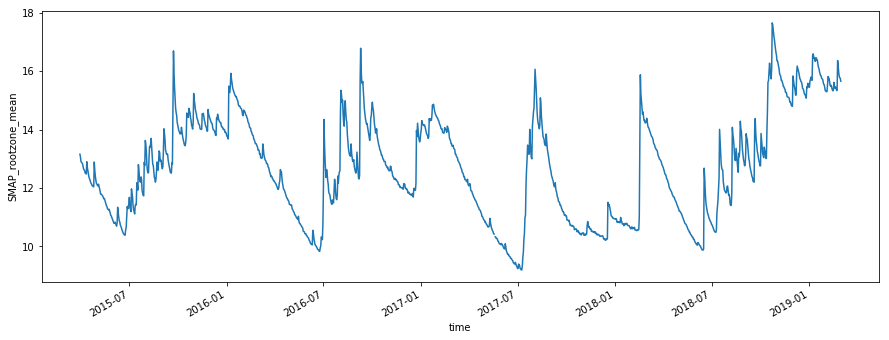

In [6]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 5]

ds["SMAP_rootzone_mean"].plot()

The `xarray.Dataset` is easily saved as a netCDF:

In [7]:
ds.to_netcdf("SMAP_rootzone-example.nc")
r, df, c, ds = None, None, None, None

-------------------------------------------------
# EASE Grid
Spatial queries to the Soil Moisture Visualizer return data corresponding to 9- by 9-km cells within the EASE grid system.

Read about the EASE grid at the NSIDC's web page:        
https://nsidc.org/data/ease


Two binary files contain the arrays corresponding to global EASE grid centroid latitudes and longitudes, respectively.         

**Open the two files and read into `numpy` arrays:**

In [8]:
lats = "docs/EASE2_M09km.lats.3856x1624x1.double"
lons = "docs/EASE2_M09km.lons.3856x1624x1.double"

# read the files to two numpy arrays
lat_array = np.fromfile(lats, dtype=np.float64).flatten()
lon_array = np.fromfile(lons, dtype=np.float64).flatten()

# zip the arrays with np.dstack
c = np.dstack((lon_array, lat_array))[0]
print("Array shape: "+str(c.shape))
c

Array shape: (6262144, 2)


array([[-179.9533195 ,   84.6564188 ],
       [-179.85995851,   84.6564188 ],
       [-179.76659751,   84.6564188 ],
       ...,
       [ 179.76659751,  -84.6564188 ],
       [ 179.85995851,  -84.6564188 ],
       [ 179.9533195 ,  -84.6564188 ]])

The most straightforward way to select coordinates inside a polygon is to first index the coordinate array using the polygon extent.

**Select a 2-dimensional array of EASE grid centroids using some arbitrary latitude, longitude bounds:** 

In [9]:
selection = c[(-90<lon_array) & (lon_array<-85) & (25<lat_array) & (lat_array<30)]
selection

array([[-89.9533195 ,  29.94568162],
       [-89.85995851,  29.94568162],
       [-89.76659751,  29.94568162],
       ...,
       [-85.19190871,  25.02339698],
       [-85.09854772,  25.02339698],
       [-85.00518672,  25.02339698]])

**Simple function uses the logic above to select an array of coordinates within bounding extent of the polygon:**

In [10]:
def get_ease(geom):
    
    # geom.bounds method returns a tuple of bounding coordinates:
    sel_minlon, sel_minlat, sel_maxlon, sel_maxlat = geom.bounds
    
    # index the xy array with bool conditions based on extent
    sel_ease = c[(sel_minlon<lon_array) & (lon_array<sel_maxlon) & 
                 (sel_minlat<lat_array) & (lat_array<sel_maxlat)]
    
    # further reduce to pts contained within the selected geometry
    sel_ease_poly = [
        pt for pt in sel_ease if geom.contains(Point(pt[0], pt[1]))]
    
    return(sel_ease_poly)

---------------------------------------------
## Reading ESRI Shapefile data using `geopandas`

+organizing the data to allow for plotting with ipyleaflet:

In [11]:
# read shapefile to geodataframe
gdf = gpd.GeoDataFrame.from_file("sites/Sites_lf.shp")  

# get geodataframe as wgs84l get centroid of each polygon
gdf = gdf.to_crs({'init': 'epsg:4326'})
gdf['centroid'] = [(p.y, p.x) for p in gdf.centroid]

# make list of colors using matplotlib's colormapper
gdf['style'] = [{
    'color': colors.rgb2hex(d[0:3]), 
    'fillColor': colors.rgb2hex(d[0:3]), 
    'weight': 1, 'fillOpacity': 0.5
} for d in cm.Set3(np.linspace(0.0,1.0,len(gdf)))]

# get geometries from geodataframe as python dictionary; get bounds
geodict = json.loads(gdf.to_json())
bnds, series = gdf.bounds, gdf['geometry']

# get extent and centroid for whole file
minx, maxx = min(bnds['minx']), max(bnds['maxx'])
miny, maxy = min(bnds['miny']), max(bnds['maxy'])
centroid = ((maxy+miny)/2, (maxx+minx)/2)

# display first two rows of geodataframe
gdf.head(2)

,OBJECTID,RANGERDIST,REGION,FORESTNUMB,DISTRICTNU,DISTRICTOR,FORESTNAME,DISTRICTNA,GIS_ACRES,SHAPE_Leng,...,STD_29,STD_30,STD_31,STD_32,STD_33,STD_34,STD_35,geometry,centroid,style
0,61,99030501010343,03,05,01,030501,Coronado National Forest,Douglas Ranger District,434025.200,3.963602,...,446.146563,453.982071,557.405375,339.841942,599.562885,470.501168,343.082608,(POLYGON ((-109.2462605499999 32.0543309500000...,"(31.774734099094076, -109.32758904395166)","{'color': '#8dd3c7', 'fillColor': '#8dd3c7', '..."
1,62,99030503010343,03,05,03,030503,Coronado National Forest,Sierra Vista Ranger District,321534.997,2.854066,...,502.615547,430.908201,701.371540,272.786808,445.029396,525.713796,242.986111,(POLYGON ((-110.6378639499999 31.6445072200000...,"(31.50507306651905, -110.53696719971344)","{'color': '#ffffb3', 'fillColor': '#ffffb3', '..."


**Test the function for selecting EASE grid points using a site from the USFS shapefile:**

In [12]:
get_ease(gdf.iloc[8].geometry)[:5]

[array([-107.22510373,   37.91860119]),
 array([-107.13174274,   37.91860119]),
 array([-107.03838174,   37.91860119]),
 array([-106.94502075,   37.91860119]),
 array([-106.85165975,   37.91860119])]

-----------------------------------------
# Building a UI in Jupyter with `ipywidgets` and `ipyleaflet`
The next couple cells are pretty long, but they provide some nice functionality for interactive query and display of the SMV data. The cell below initializes the widgets that we'll draw in the cells to come:

1. Make `ipyleaflet` map widget
2. Make map layer of USFS sites from the `geopandas` data frame created above
3. Make a submit button to begin sending series of requests to the SMV
4. Make progress bar to monitor progress of the requests

In [13]:
layer = mwg.GeoJSON(                                                 # 1
    data=geodict, 
    hover_style={'color': "white", 'weight': 2, 'fillOpacity': 0.8}) 

m = mwg.Map(                                                         # 2
    layers=(layer, mwg.basemap_to_tiles(mwg.basemaps.Esri.WorldImagery)), 
    center=(33, -109), 
    zoom=6, 
    scroll_wheel_zoom=True)

submit = wg.Button(                                                  # 3
    description='Submit', 
    disabled=True, 
    button_style='success',    
    tooltip='Click to submit requests for each EASE grid point.')

progress_bar = wg.IntProgress(                                       # 4
    description="Progress: ", layout=wg.Layout(width="95%"))

### Add interaction handlers
click handler calls `get_ease` upon polygon click, reduces array of ease grid centroids using polygon extent, uses shapely `contains()` to determine if point is inside polygon (geopandas is basically pandas with shapely geometry column), makes feature and adds to layer group.

*note: `samples` will be a global variable that is updated with the most recently selected list of EASE grid sample coordinates*

In [14]:
def button_click_handler(b):
    global samples
    progress_bar.min = 0                          # set min,
    progress_bar.max = len(samples["pts"].keys()) # max, 
    progress_bar.value = 0                        # and reset

    # iterate over sample points
    for i, pt in samples["pts"].items():
        x, y = pt["xy"]
        
        # add map pt, update progress bar
        progress_bar.value += 1
        samples["lyr"].add_layer(
            mwg.CircleMarker(
                location=(y, x),
                stroke=True,
                stroke_width=2,
                radius=10, 
                color="orange"))
        
        # submit request to SMV; get pandas df; get coordinate arrays
        df = smvrequest(i, y, x)
        c = getsample(sample=i, lat=y, lon=x)
        
        # iterate over cols and make dict of xarray.Datasets
        for col in list(df):
            ds = getxr(df[col])                   # parse col to xr
            ds["sample_name"], ds['lat'], ds['lon'] = c[1:] # crds
            ds.attrs = getatts(col)               # add attributes
            samples["pts"][i]["data"][col] = ds   # add to dict


def layer_click_handler(**kwargs):
    global samples
    if "id" not in kwargs.keys():
        return(None)
    
    g = gdf.iloc[int(kwargs['id'])]     # geopandas row for selected
    geom = g.geometry                   # selected geom
    centroid = geom.centroid            # centroid of selected geom
    m.center = (centroid.y, centroid.x) # center map
    m.zoom = 9                          # zoom map
    easepts = get_ease(geom)            # get EASE centroids for geom
    
    try:                                # try to grab active map lyr
        m.remove_layer(samples["lyr"])
    except:                             # ignore exceptions
        pass                
    finally:                            # reset samples dict
        samples = {"pts": {}, "lyr": mwg.LayerGroup()}
             
        for i, pt in enumerate(easepts):# make point layers

            samples["lyr"].add_layer(   # lyr for map pts
                mwg.CircleMarker(       
                    location=(pt[1], pt[0]), 
                    stroke=False, 
                    radius=5, 
                    fill_color="black", 
                    fill_opacity=0.6))
            
            samples["pts"][i] = {
                "xy": (pt[0], pt[1]),  # lon, lat tuple
                "data": {}}            # data dict

    m.add_layer(samples["lyr"])   # add layer to map
    submit.disabled = False

samples = None                         # becomes dict for samples
submit.on_click(button_click_handler)  # set submit bttn callback
layer.on_click(layer_click_handler)    # set layer click callback

Display the widgets:

In [15]:
wg.VBox([m, wg.HBox([submit, progress_bar])])

**This is how you would concatenate each dataset along the "sample" dimension (see CF Conventions for `featureType: "timeSeries"`):**

In [16]:
dsmerges = {}
for ds in smvds.index.tolist():
    try:
        dslist = [d["data"][ds] for s,d in samples["pts"].items()]
        dsmerges[ds] = xr.concat(dslist, "sample")
    except:
        print("Failed to concat "+str(ds)+". May be entirely nodata.")

Failed to concat SoilSCAPE_surface. May be entirely nodata.
Failed to concat SoilSCAPE_rootzone. May be entirely nodata.
Failed to concat AirMOSS_in-ground_surface. May be entirely nodata.
Failed to concat AirMOSS_in-ground_rootzone. May be entirely nodata.
Failed to concat COSMOS_surface. May be entirely nodata.
Failed to concat COSMOS_rootzone. May be entirely nodata.
Failed to concat AirMOSS_L2_3_surface. May be entirely nodata.
Failed to concat AirMOSS_L2_3_rootzone. May be entirely nodata.
Failed to concat AirMOSS_L4_rootzone. May be entirely nodata.
Failed to concat SMAP_surface. May be entirely nodata.
Failed to concat SMAP_rootzone. May be entirely nodata.
Failed to concat NEE_mean. May be entirely nodata.
Failed to concat GPP_mean. May be entirely nodata.
Failed to concat GRACE_surface_pctl. May be entirely nodata.
Failed to concat GRACE_rootzone_pctl. May be entirely nodata.
Failed to concat SCAN_surface. May be entirely nodata.
Failed to concat SCAN_rootzone. May be entirely

**Now, merge the datasets to a single xarray.Dataset:**

In [17]:
complete_dataset = xr.merge(dsmerges.values())
complete_dataset

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*

Save a copy:

In [18]:
complete_dataset.to_netcdf("complete_dataset.nc")

## Getting started with the plotting part:

Find a better way to omit time series that are entirely no data. For now this loop works:

In [19]:
plotseries = {}
for array in complete_dataset:
    if array is "sample_name":
        pass
    else:
        array_mean = complete_dataset[array].mean().data
        if np.isnan(array_mean):
            print("Skipping: "+array)
        else:
            plotseries[array] = complete_dataset[array]

Plot the remainder:

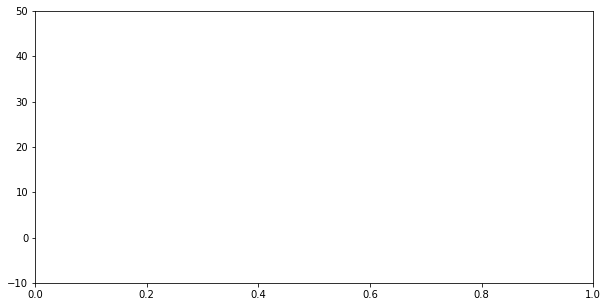

In [20]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

fig = plt.figure()
for name, data in plotseries.items():
    if "mean" in name:
        data[0].plot()

plt.ylim(top=50, bottom=-10)
plt.draw()

# other working plots:
Two interactivity/display options:
* %matplotlib notebook
* %matplotlib inline

```
plt.rcParams['figure.figsize'] = [10, 20]
# ----------------------------------------------------------------------------
plotable = {}
for v in samples[0].keys():
    if not np.isnan(samples[0][v]['Mean'].mean().data):
        plotable[v] = samples[0][v]
        
sample.options = list(plotable.keys())
sample.value = list(plotable.keys())[0]
print(plotable.keys())

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

fig = plt.figure()
for name, data in plotable.items():
    data['Mean'].plot()

plt.ylim(top=50, bottom=-10)
plt.draw()
# ----------------------------------------------------------------------------
```

# old code
**maybe we don't display the hovers. it's kinda hack-y implementation. ipyleaflet map widget doesn't have great options for this type of interaction. this is the purged hover handler ocde:**
```
def hover_handler(event=None, id=None, properties=None):
    if len(m.layers)==3:
        m.remove_layer(m.layers[-1])

    nyears = len([key for key in properties.keys() if "MEAN" in key])
    data = {'year': [], 'mean': [], 'std': []}
    for i in range(1,nyears):
        data['year'].append(1980+i)
        data['mean'].append(properties["MEAN_"+str(i)])
        data['std'].append(properties["STD_"+str(i)])
    df = pd.DataFrame(data)
        
    popup = mwg.Popup(location=properties['centroid'], 
                      child=wg.HTML("{put some info here}"), 
                      auto_close=True,
                      class_name="custom")
    m.add_layer(popup)
    
layer.on_hover(hover_handler)
m.add_layer(layer)
m
```
**purged imports:**
```
import math
import matplotlib as mpl
import matplotlib.pyplot as plt, mpld3
mpl.rcParams['figure.figsize'] = [8, 7]
```

**layer group:**
```
# make layer group
point_group = mwg.LayerGroup(layers=tuple(point_features))
```

## not using geojson points anymore:
**GeoJSON point features look like this:**

```
geojsonpt = '''
{{
    "type": "Feature",
    "properties": {properties},
    "geometry": {{
        "type": "Point",
        "coordinates": [{lon},{lat}]
    }}
}}
'''
print(geojsonpt.format(lat="30", lon="-90", properties="{}"))
```